In [1]:
import optuna
import warnings
import gc
import os
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime
from glob import glob
from tqdm import tqdm
from IPython.display import Image

In [2]:
# 추후에 경고 값들을 출력하지 않도록 'ignore'상태로 만들어 준다.
# 불필요한 경고창이 더 이상 출력 되지 않게 됩니다.
warnings.filterwarnings(action = 'ignore')

In [5]:
train_2017 = []
train_2018 = []
train_2019 = []
train_2020 = []

for i, path in enumerate(sorted(glob("/Users/home/Downloads/KNOW_data/train/*.csv"))):
    if i == 0:
        train_2017 = pd.read_csv(path)
        pass
    elif i==1:
        train_2018 = pd.read_csv(path)
        pass
    elif i==2:
        train_2019 = pd.read_csv(path)
        pass
    else:
        train_2020 = pd.read_csv(path)
        pass
    
test_2017 = []
test_2018 = []
test_2019 = []
test_2020 = []

for i, path in enumerate(sorted(glob("/Users/home/Downloads/KNOW_data/test/*.csv"))):
    if i == 0:
        test_2017 = pd.read_csv(path)
        pass
    elif i==1:
        test_2018 = pd.read_csv(path)
        pass
    elif i==2:
        test_2019 = pd.read_csv(path)
        pass
    else:
        test_2020 = pd.read_csv(path)
        pass

In [6]:
# 데이터의 결측치 값이 ' '기준으로 나타나기 때문에 결측치가 보이지 않는다.
train_2017.isnull().sum()

idx         0
aq1_1       0
aq1_2       0
aq2_1       0
aq2_2       0
           ..
bq40        0
bq41_1      0
bq41_2      0
bq41_3      0
knowcode    0
Length: 156, dtype: int64

In [7]:
# 결측치 값 확인을 편하게 하기 위해서 모두 np.nan 값으로 바꿔준다
# train_2017에 있는 모든 columns들을 불러온다.
for col in train_2017:
        train_2017[col].replace(' ', np.nan, inplace = True)
        if col != 'knowcode':
            test_2017[col].replace(' ', np.nan, inplace = True)

In [8]:
# 정상적으로 결측치 값이 나타나는 것을 확인할 수 있습니다.
train_2017.isnull().sum()

idx            0
aq1_1          0
aq1_2        585
aq2_1          0
aq2_2        861
            ... 
bq40        1301
bq41_1      1332
bq41_2      8222
bq41_3      1316
knowcode       0
Length: 156, dtype: int64

In [9]:
# 중요하지 않다라고 한 사람들에 대한 
# 결측치 값을 0으로 바꿔준다.
# aq1_1 에서부터 aq41_2 까지의 칼럼들을 뽑아 낸다.
columns = train_2017.columns[1:-1][:82]

# 앞의 결측치 값을 제거하면 뒤의 결측치 값은 제거하면 되기 때문에
# 데이터의 인덱스를 2씩 키운다.
for index in range(0,82,2):
    col = columns[index]
    
    # before가 가번 문항에 해당한다. 
    # after는 나번 문항에 해당한다. 
    before = col
    after = col[:-1] + str((int(col[-1])+1))
    print(before, after)
    
    # 일단 before 자체도 결측치 값이면 안된다.
    # 그리고 after 값이 결측치 값인 것을 확인한다.
    # after 값이 결측치 값이라는 것은 가번 문항에서 1번 을 선택한 것이기 때문에 0으로 할당해 줘야 한다.
    train_2017.loc[(train_2017[after].isnull()) & (train_2017[before].notnull()) & (train_2017[before] == (sorted(train_2017[before].unique()))[0]), after] = 0
    test_2017.loc[(test_2017[after].isnull()) & (test_2017[before].notnull()) & (test_2017[before] == (sorted(test_2017[before].unique()))[0]), after] = 0

aq1_1 aq1_2
aq2_1 aq2_2
aq3_1 aq3_2
aq4_1 aq4_2
aq5_1 aq5_2
aq6_1 aq6_2
aq7_1 aq7_2
aq8_1 aq8_2
aq9_1 aq9_2
aq10_1 aq10_2
aq11_1 aq11_2
aq12_1 aq12_2
aq13_1 aq13_2
aq14_1 aq14_2
aq15_1 aq15_2
aq16_1 aq16_2
aq17_1 aq17_2
aq18_1 aq18_2
aq19_1 aq19_2
aq20_1 aq20_2
aq21_1 aq21_2
aq22_1 aq22_2
aq23_1 aq23_2
aq24_1 aq24_2
aq25_1 aq25_2
aq26_1 aq26_2
aq27_1 aq27_2
aq28_1 aq28_2
aq29_1 aq29_2
aq30_1 aq30_2
aq31_1 aq31_2
aq32_1 aq32_2
aq33_1 aq33_2
aq34_1 aq34_2
aq35_1 aq35_2
aq36_1 aq36_2
aq37_1 aq37_2
aq38_1 aq38_2
aq39_1 aq39_2
aq40_1 aq40_2
aq41_1 aq41_2


In [10]:
train_2017['aq1_1'].value_counts()

3    3116
4    3007
2    1706
5    1072
1     585
Name: aq1_1, dtype: int64

In [11]:
train_2017[(train_2017['aq11_2'].isnull())]['aq11_1']

89      3
577     3
2422    3
4568    3
Name: aq11_1, dtype: int64

In [12]:
total_2017 = pd.concat([train_2017[(train_2017['aq11_2'].notnull()) & (train_2017['aq11_1'] == 3)], test_2017[(test_2017['aq11_2'].notnull()) & (test_2017['aq11_1'] == 3)]], axis = 0)

In [13]:
train_2017.loc[train_2017['aq11_2'].isnull(),'aq11_2']=4

In [14]:
test_2017.loc[test_2017['aq11_2'].isnull(),'aq11_2']=4

In [15]:
train_2017['aq11_2'].value_counts()


0    2741
4    1601
5    1414
3    1366
2    1060
6     830
7     314
1     156
4       4
Name: aq11_2, dtype: int64

In [16]:
print(sum(train_2017['aq11_2'].isnull()))
print(sum(test_2017['aq11_2'].isnull()))

0
0


In [17]:
train_2017.loc[(train_2017['aq14_2'].isnull()),'aq14_1']

3137    4
4564    4
6539    3
Name: aq14_1, dtype: int64

In [18]:
test_2017.loc[(test_2017['aq14_2'].isnull()),'aq14_1']

723     3
1234    3
1452    3
2026    3
3083    3
5078    4
6270    3
7139    3
7320    3
Name: aq14_1, dtype: int64

In [19]:
# 가번 문항에서 3번을 선택한 사람의 중앙 값을 알기 위해서 전체 데이터로 합친다.
total_2017 = pd.concat([train_2017[(train_2017['aq14_2'].notnull()) & (train_2017['aq14_1'] == 3)], test_2017[(test_2017['aq14_2'].notnull()) & (test_2017['aq14_1'] == 3)]], axis = 0)
total_2017.shape

(6335, 156)

In [20]:
train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 3),'aq14_2'] ='3'
test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 3),'aq14_2'] = '3'

In [21]:
# 가번 문항에서 4번을 선택한 사람의 중앙 값을 알기 위해서 전체 데이터로 합친다.
total_2017 = pd.concat([train_2017[(train_2017['aq14_2'].notnull()) & (train_2017['aq14_1'] == 4)], test_2017[(test_2017['aq14_2'].notnull()) & (test_2017['aq14_1'] == 4)]], axis = 0)
total_2017.shape

(4713, 156)

In [22]:
train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 4),'aq14_2'] = '5'
test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 4),'aq14_2'] = '5'

In [23]:
train_2017['aq14_2'].value_counts()

4    2193
5    1733
3    1605
0    1547
2    1138
6     918
7     204
1     148
Name: aq14_2, dtype: int64

In [24]:
print(sum(train_2017['aq14_2'].isnull()))
print(sum(test_2017['aq14_2'].isnull()))

0
0


In [25]:
train_2017[(train_2017['aq27_2'].isnull())]['aq27_1']

715     3
792     3
3960    3
4060    3
5388    3
6383    4
9449    3
Name: aq27_1, dtype: int64

In [26]:
test_2017[(test_2017['aq27_2'].isnull())]['aq27_1']

2302    3
2479    3
2667    3
3334    4
6279    3
8052    3
Name: aq27_1, dtype: int64

count    6076.000000
mean        3.742429
std         0.743687
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq27_2, dtype: float64


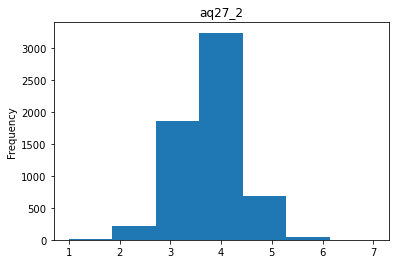

In [27]:
# 가번 문항에서 3번을 선택한 사람을 우선적으로 처리한다.

total_2017 = pd.concat([train_2017[(train_2017['aq27_2'].notnull()) & (train_2017['aq27_1'] == 3)], test_2017[(test_2017['aq27_2'].notnull()) & (test_2017['aq27_1'] == 3)]], axis = 0)

print(total_2017['aq27_2'].astype('int').describe())

total_2017['aq27_2'].astype('int').plot.hist(bins = 7, title = "aq27_2")





In [28]:
train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 3),'aq27_2'] = '4'
test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 3),'aq27_2'] = '4'

count    4277.000000
mean        4.842413
std         0.856356
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: aq27_2, dtype: float64


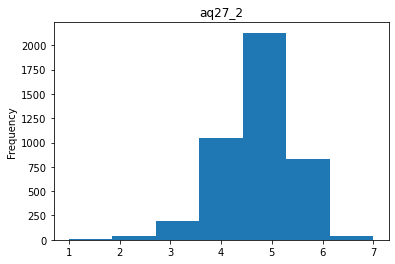

In [29]:
# 가번 문항에서 4번을 선택한 사람을 처리한다.

total_2017 = pd.concat([train_2017[(train_2017['aq27_2'].notnull()) & (train_2017['aq27_1'] == 4)], test_2017[(test_2017['aq27_2'].notnull()) & (test_2017['aq27_1'] == 4)]], axis = 0)

print(total_2017['aq27_2'].astype('int').describe())

total_2017['aq27_2'].astype('int').plot.hist(bins = 7, title = "aq27_2")



#display(train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 4)])
#display(test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 4)])

In [30]:
train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 4),'aq27_2'] = '5'
test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 4),'aq27_2'] = '5'

In [31]:
test_2017['aq27_2'].value_counts()

4    2326
3    1781
0    1701
5    1517
2    1225
6     639
7     165
1     132
Name: aq27_2, dtype: int64

In [32]:
test_2017[(test_2017['aq32_2'].isnull())]['aq32_1']

1362     3
1651     3
2854     3
3194     3
3216     3
3280     3
7749    33
8775     3
8811     3
8853     3
Name: aq32_1, dtype: int64

In [33]:
test_2017.loc[(test_2017['aq32_1'] == 33), 'aq32_1'] = 3
test_2017.loc[(test_2017['aq32_2'].isnull()),'aq32_1']

1362    3
1651    3
2854    3
3194    3
3216    3
3280    3
7749    3
8775    3
8811    3
8853    3
Name: aq32_1, dtype: int64

count    4844.000000
mean        3.781379
std         0.824401
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq32_2, dtype: float64


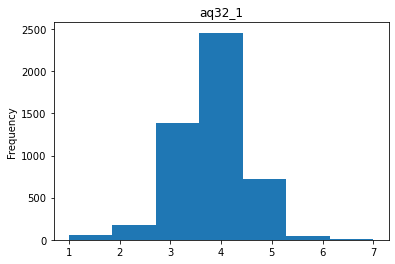

In [34]:
# 가번 문항을 3으로 선택한 사람들에 대한 결측치 값을 처리한다. 

total_2017 = pd.concat([train_2017[(train_2017['aq32_2'].notnull()) & (train_2017['aq32_1'] == 3)], test_2017[(test_2017['aq32_2'].notnull()) & (test_2017['aq32_1'] == 3)]], axis = 0)

print(total_2017['aq32_2'].astype('int').describe())

total_2017['aq32_2'].astype('int').plot.hist(bins = 7, title = "aq32_1")



#display(train_2017.loc[(train_2017['aq32_2'].isnull()) & (train_2017['aq32_1'] == 3)])
#display(test_2017.loc[(test_2017['aq32_2'].isnull()) & (test_2017['aq32_1'] == 3)])

In [35]:
train_2017.loc[(train_2017['aq32_2'].isnull()) & (train_2017['aq32_1'] == 3),'aq32_2'] = '4'
test_2017.loc[(test_2017['aq32_2'].isnull()) & (test_2017['aq32_1'] == 3),'aq32_2'] = '4'

In [36]:
train_2017['aq32_2'].value_counts()

0    2643
4    1754
5    1517
3    1414
2    1064
6     654
7     228
1     212
Name: aq32_2, dtype: int64

In [37]:
train_2017.loc[(train_2017['aq41_2'].isnull()),'aq41_1']

1798    3
6894    3
7118    3
8289    3
Name: aq41_1, dtype: int64

In [38]:
test_2017.loc[(test_2017['aq41_2'].isnull()),'aq41_1']

1284    3
3460    3
5419    3
6893    3
8305    3
Name: aq41_1, dtype: int64

count    4290.000000
mean        3.729604
std         0.840835
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq41_2, dtype: float64


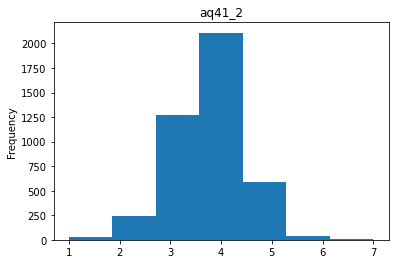

In [39]:
# 가번 문항을 3으로 선택한 사람들에 대한 결측치 값을 처리한다. 

total_2017 = pd.concat([train_2017[(train_2017['aq41_2'].notnull()) & (train_2017['aq41_1'] == 3)], test_2017[(test_2017['aq41_2'].notnull()) & (test_2017['aq41_1'] == 3)]], axis = 0)

print(total_2017['aq41_2'].astype('int').describe())

total_2017['aq41_2'].astype('int').plot.hist(bins = 7, title = "aq41_2")



#display(train_2017.loc[(train_2017['aq41_2'].isnull()) & (train_2017['aq41_1'] == 3)])
#display(test_2017.loc[(test_2017['aq41_2'].isnull()) & (test_2017['aq41_1'] == 3)])

In [40]:
train_2017.loc[(train_2017['aq41_2'].isnull()) & (train_2017['aq41_1'] == 3),'aq41_2'] = '4'
test_2017.loc[(test_2017['aq41_2'].isnull()) & (test_2017['aq41_1'] == 3),'aq41_2'] = '4'

In [41]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

In [42]:
train_2017.to_csv("2017전처리.csv",encoding="UTF-8")
test_2017.to_csv("2017_t전처리.csv",encoding="UTF-8")

In [43]:
train_2017['bq35'].unique()
train_2017[train_2017['bq35']=='4']=4
train_2017[train_2017['bq35']=='3']=3
train_2017[train_2017['bq35']=='5']=5

In [44]:
train_2017['bq35'].unique()

array([4, 2, 1, 3, 5])

In [45]:
print(train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1a'].isnull())].shape)
print(test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1a'].isnull())].shape)

(5386, 156)
(5433, 155)


In [46]:
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1a'].isnull()), 'bq4_1a'] = '없음'
test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1a'].isnull()), 'bq4_1a'] = '없음'

In [47]:
# 정상적으로 결측치 값이 제거되었다.
display(train_2017[(train_2017['bq4_1a'].isnull())])
display(test_2017[(test_2017['bq4_1a'].isnull())])

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

In [48]:
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

In [49]:
for index in train_2017.loc[(train_2017['bq4_1b'].isnull())]['bq4_1a'].index:
    value = train_2017.iloc[index]['bq4_1a']
#     col_index = np.where(train_2017.columns == 'bq4_1a')[0][0]

    if len(train_2017[(train_2017['bq4_1a'] == value) & (train_2017['bq4_1b'].notnull()) & (train_2017['bq4_1b'] != '없음') & (train_2017['bq4_1b'] != '없다')]) > 0:
         train_2017.loc[index, 'bq4_1b'] = train_2017[(train_2017['bq4_1a'] == value) & (train_2017['bq4_1b'].notnull()) & (train_2017['bq4_1b'] != '없음') & (train_2017['bq4_1b'] != '없다')]['bq4_1b'].value_counts().index[0]

In [50]:
# 위에 해당하는 사항이 없다면 '없음' 값으로 초기화 한다.
train_2017.loc[(train_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
test_2017.loc[(test_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'

In [51]:
train_2017.loc[(train_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'
test_2017.loc[(test_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

In [52]:
train_2017['bq4_1c'].value_counts()

없음             9229
없다               50
건축물에너지평가사         4
전기공사기사            4
전기기사              4
               ... 
토질 및 기초 기술사       1
비파괴검사기사           1
정보처리기사(기술사)       1
원감자격증             1
CISA              1
Name: bq4_1c, Length: 180, dtype: int64

In [53]:
# '없다'라는 값을 '없음'으로 통일해 준다.
for col in test_2017:
    train_2017[col].replace('없다','없음', inplace = True)
    test_2017[col].replace('없다','없음', inplace = True)    

In [54]:
print("학습 데이터 결측치 : ", train_2017[(train_2017['bq5'] == 2) & (train_2017['bq5_1'].isnull())].shape)
print("테스트 데이터 결측치 : ", test_2017[(test_2017['bq5'] == 2) & (test_2017['bq5_1'].isnull())].shape)

학습 데이터 결측치 :  (4976, 156)
테스트 데이터 결측치 :  (4774, 155)


In [55]:
# 5번 문항에서 2번을 선택한 사람들에 대해서 5-1에 대한 값을 0으로 처리함
train_2017.loc[(train_2017['bq5'] == 2) & (train_2017['bq5_1'].isnull()),'bq5_1'] = 0
test_2017.loc[(test_2017['bq5'] == 2) & (test_2017['bq5_1'].isnull()),'bq5_1'] = 0

In [56]:
# 5번 문항에서 2번을 선택한 사람들에 대해서 5-2에 대한 값을 '없음'으로 처리함
train_2017.loc[(train_2017['bq5'] == 2) & (train_2017['bq5_2'].isnull()),'bq5_2'] = '없음'
test_2017.loc[(test_2017['bq5'] == 2) & (test_2017['bq5_2'].isnull()),'bq5_2'] = '없음'

In [57]:
# 학습 데이터와 테스트 데이터에서 한 개씩 결측치 값이 남는다.
display(train_2017[train_2017['bq5_2'].isnull()])
display(test_2017[test_2017['bq5_2'].isnull()])

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ...  \
5277  5277      3     4      2     3      3     4      1     0      3  ...   

     bq37  bq38 bq38_1  bq39_1 bq39_2  bq40 bq41_1  bq41_2 bq41_3  knowcode  
5277   54     3     기계       1      1     1   3000     NaN   2000     28204  

[1 rows x 156 columns]

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ...  \
7264  7264      4     5      4     5      4     5      1     0      3  ...   

     bq36  bq37 bq38  bq38_1 bq39_1  bq39_2 bq40  bq41_1 bq41_2  bq41_3  
7264    2    45    3    호텔경영      1       1    1    2800    NaN    2000  

[1 rows x 155 columns]

In [58]:
# train과 test 모두 필요한 자격증 값이 '없음'이기 때문에 단순히 유추하기 어렵다.
# 따라서, '없음'으로 전처리 해준다.
train_2017.loc[train_2017['bq5_2'].isnull(), 'bq5_2'] = '없음'
test_2017.loc[test_2017['bq5_2'].isnull(), 'bq5_2'] = '없음'

In [59]:
# bq12_2 컬럼에 대한 결측치를 제거한다.

for idx in train_2017.loc[(train_2017['bq12_2'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[idx]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[idx, 'bq12_2'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int').astype('str')

In [60]:
train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int')

3

In [61]:
# bq12_2 컬럼에 대한 결측치를 제거한다.

for idx in test_2017.loc[(test_2017['bq12_2'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[idx]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[idx, 'bq12_2'] = test_2017[(test_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int').astype('str')

In [62]:
train_2017['bq12_2']

0       3
1       3
2       4
3       3
4       3
       ..
9481    4
9482    3
9483    3
9484    3
9485    5
Name: bq12_2, Length: 9486, dtype: object

In [63]:
train_2017['bq12_4']

0       4
1       4
2       4
3       3
4       4
       ..
9481    4
9482    3
9483    4
9484    4
9485    5
Name: bq12_4, Length: 9486, dtype: object

In [64]:
# bq12_3 컬럼에 대한 결측치를 제거한다.

for idx in train_2017.loc[(train_2017['bq12_3'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[idx]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[idx, 'bq12_3'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_3'].notnull())]['bq12_3'].astype('int').quantile(q=0.5).astype('int').astype('str')
    
for idx in test_2017.loc[(test_2017['bq12_3'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[idx, 'bq12_3'] = test_2017[(test_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_3'].notnull())]['bq12_3'].astype('int').quantile(q=0.5).astype('int').astype('str')    

In [65]:
# bq12_4 컬럼에 대한 결측치를 제거한다.

for idx in train_2017.loc[(train_2017['bq12_4'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[idx]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[idx, 'bq12_4'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_4'].notnull())]['bq12_4'].astype('int').quantile(q=0.5).astype('int').astype('str')

for idx in test_2017.loc[(test_2017['bq12_4'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[idx]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[idx, 'bq12_4'] = test_2017[(train_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_4'].notnull())]['bq12_4'].astype('int').quantile(q=0.5).astype('int').astype('str')

In [66]:
train_2017['bq36'].unique()

array([1, 2])

In [67]:
train_2017.loc[train_2017['bq19_1'].isnull(),'bq19_1'] = '없음'
test_2017.loc[test_2017['bq19_1'].isnull(),'bq19_1'] = '없음'

In [68]:
# 직전에 직업이 었는 사람인 것을 확인 했다.
# 따라서 별도의 직업을 달리 부르는 명칭이 존재하지 않는다.
print(test_2017[test_2017['bq30'].isnull()]['bq32'])
test_2017.loc[test_2017['bq30'].isnull(),'bq32'] = '없음'

1897    없음
Name: bq32, dtype: object


In [69]:
for idx, val, tidx, tval in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print("{}:{} / {}:{}/{}".format(idx,val,tidx,tval,val+tval))

idx:0 / idx:0/0
aq1_1:0 / aq1_1:0/0
aq1_2:0 / aq1_2:0/0
aq2_1:0 / aq2_1:0/0
aq2_2:0 / aq2_2:0/0
aq3_1:0 / aq3_1:0/0
aq3_2:0 / aq3_2:0/0
aq4_1:0 / aq4_1:0/0
aq4_2:0 / aq4_2:0/0
aq5_1:0 / aq5_1:0/0
aq5_2:0 / aq5_2:0/0
aq6_1:0 / aq6_1:0/0
aq6_2:0 / aq6_2:0/0
aq7_1:0 / aq7_1:0/0
aq7_2:0 / aq7_2:0/0
aq8_1:0 / aq8_1:0/0
aq8_2:0 / aq8_2:0/0
aq9_1:0 / aq9_1:0/0
aq9_2:0 / aq9_2:0/0
aq10_1:0 / aq10_1:0/0
aq10_2:0 / aq10_2:0/0
aq11_1:0 / aq11_1:0/0
aq11_2:0 / aq11_2:0/0
aq12_1:0 / aq12_1:0/0
aq12_2:0 / aq12_2:0/0
aq13_1:0 / aq13_1:0/0
aq13_2:0 / aq13_2:0/0
aq14_1:0 / aq14_1:0/0
aq14_2:0 / aq14_2:0/0
aq15_1:0 / aq15_1:0/0
aq15_2:0 / aq15_2:0/0
aq16_1:0 / aq16_1:0/0
aq16_2:0 / aq16_2:0/0
aq17_1:0 / aq17_1:0/0
aq17_2:0 / aq17_2:0/0
aq18_1:0 / aq18_1:0/0
aq18_2:0 / aq18_2:0/0
aq19_1:0 / aq19_1:0/0
aq19_2:0 / aq19_2:0/0
aq20_1:0 / aq20_1:0/0
aq20_2:0 / aq20_2:0/0
aq21_1:0 / aq21_1:0/0
aq21_2:0 / aq21_2:0/0
aq22_1:0 / aq22_1:0/0
aq22_2:0 / aq22_2:0/0
aq23_1:0 / aq23_1:0/0
aq23_2:0 / aq23_2:0/0
aq24_1:0

In [70]:
for index in test_2017[(test_2017['bq31'].isnull())].index:
    # 산업 유형
    industry_type = test_2017.iloc[index]['bq1']
    # 유사직업명
    a_similar_job = test_2017.iloc[index]['bq30']
    # 직전직업
    before_job = test_2017.iloc[index]['bq32']
    # 전직 가능직업
    can_change_job = test_2017.iloc[index]['bq33']

    if len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job) & (
                              test_2017['bq33'] == can_change_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업 + 전직 가능 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job) & (
                        test_2017['bq33'] == can_change_job)]['bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)][
            'bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job) & (
            test_2017['bq32'] == before_job) & (test_2017['bq33'] == can_change_job)]):
        #  유사 직업명 + 직전 직업 + 전직 가능 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job) & (
                        test_2017['bq32'] == before_job) & (test_2017['bq33'] == can_change_job)][
            'bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job)]):
        # 산업 유형 + 유사 직업명
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job)]['bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)]):
        # 산업 유형 + 직전 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)].value_counts().index[
            0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job) & (
            test_2017['bq33'] == can_change_job)]):
        # 직전 직업 + 전직 가능직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job) & (
                        test_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job)]):
        # 직전 직업
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq33'] == can_change_job)]):
        # 전직 가능직업
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job)]):
        # 유사 직업명
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job)].value_counts().index[0]
    else:
        # 이정도면 없음으로 할게요...
        test_2017.loc[index, 'bq31'] = '없음'


In [71]:
train_2017.loc[train_2017['bq32'].isnull(), 'bq32'] = '모름' 
test_2017.loc[test_2017['bq32'].isnull(), 'bq32'] = '모름' 

In [72]:
train_2017.loc[(train_2017['bq34'].isnull()), 'bq34'] = '모름'
test_2017.loc[(test_2017['bq34'].isnull()), 'bq34'] = '모름'

In [73]:
print(f"train : {train_2017[train_2017['bq38_1'].isnull()]['bq38'].shape[0]}")
print(f"test : {test_2017[test_2017['bq38_1'].isnull()]['bq38'].shape[0]}")

train : 271
test : 278


In [74]:
train_2017.loc[train_2017['bq38_1'].isnull(),'bq38_1'] = '없음'
test_2017.loc[test_2017['bq38_1'].isnull(),'bq38_1'] = '없음'

In [75]:
print(train_2017[(train_2017['bq40'].isnull())]['bq39_2'].value_counts())
print(test_2017[(test_2017['bq40'].isnull())]['bq39_2'].value_counts())

6    668
5    601
7     32
Name: bq39_2, dtype: int64
6    683
5    609
7     41
Name: bq39_2, dtype: int64


In [76]:
train_2017.loc[(train_2017['bq39_1'] == 2) & (train_2017['bq40'].isnull()),'bq40'] = '3'
test_2017.loc[(test_2017['bq39_1'] == 2) & (test_2017['bq40'].isnull()),'bq40'] = '3'

In [77]:
train_2017 = train_2017.drop(columns = ['bq41_1', 'bq41_2', 'bq41_3'])
test_2017 = test_2017.drop(columns = ['bq41_1', 'bq41_2', 'bq41_3'])

In [78]:
train_2017.loc[train_2017['bq33'].isnull(), 'bq33'] = '모름' 
test_2017.loc[test_2017['bq33'].isnull(), 'bq33'] = '모름' 

In [79]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

In [80]:
train_2017.loc[train_2017['bq31'].isnull(),'bq31']='없음'
test_2017.loc[test_2017['bq31'].isnull(),'bq31']='없음'

In [81]:
test_2017.loc[test_2017['bq30'].isnull(),'bq30']="없음"

In [82]:
train_2017['bq37'].unique()

array([52, 38, 50, 42, 51, 41, 39, 45, 58, 53, 30, 61, 26, 34, 40, 28, 29,
       48, 63, 37, 44, 36, 47, 56, 59, 43, 33, 65, 35, 72, 32, 57, 22, 25,
       78, 68, 60, 46, 67, 54, 27, 31, 55, 64, 49, 23, 71, 66, 62, 69, 24,
       20, 19, 73, 75, 21, 70, 76, 74, 87, 77, 82, 88])

In [83]:
train_2017.to_csv("2017train.csv",encoding="UTF-8")
test_2017.to_csv("2017test.csv",encoding="UTF-8")